In [83]:
import cv2
import os
import numpy as np
from random import shuffle
import imutils #need to install this with pip
import matplotlib.pyplot as plt
from skimage import data, color, exposure
from sklearn import svm
import data_generator as dg
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline
import glob

In [84]:

pimages = [cv2.imread(file) for file in glob.glob("mushroom/*.jpg")]
print(len(images), "positive images")

103 positive images


In [85]:

#get negative images, use ratios found for positive images to match
nimages = dg.getRandomMultiple("sun_images", 200, 0)
nimages = [x[1] for x in nimages]

print(len(nimages), "negative images")

200 negative images


In [86]:
minDim = 80
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9

dims = (minDim, minDim)

hog = cv2.HOGDescriptor(dims, blockSize, blockStride, cellSize, nbins)

In [87]:
for i in range(len(images)):
    cv2.resize(images[i], (80, 80))

In [88]:
def getFeaturesWithLabel(imageData, hog, dims, label):
    data = []
    for img in imageData: 
        img = cv2.resize(img, dims)

        #for images with transparency layer, reduce to 3 layers
        feat = hog.compute(img[:,:,:3])
        
        data.append((feat, label))
    return data

In [89]:
pdata = getFeaturesWithLabel(pimages, hog, dims, 1)
ndata = getFeaturesWithLabel(nimages, hog, dims, 0)

data = pdata + ndata
shuffle(data)

feat, labels = map(list, zip(*data))
feat = [x.flatten() for x in feat]

sample_size = len(feat)
train_size = int(round(0.8*sample_size))

train_feat = np.array(feat[:train_size], np.float32)
test_feat = np.array(feat[train_size: sample_size], np.float32)
train_label = np.array(labels[:train_size])
test_label = np.array(labels[train_size:sample_size])

In [90]:
lsvm = svm.SVC(kernel='linear', C = 1.0, probability=True)
lsvm.fit(train_feat, train_label)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [91]:
print(lsvm.score(train_feat, train_label))

1.0


In [92]:
#compute test accuracy
print("test accuracy ", lsvm.score(test_feat, test_label))
y_pred = lsvm.predict(test_feat)
print(classification_report(test_label, y_pred))

test accuracy  0.918032786885
             precision    recall  f1-score   support

          0       0.89      0.97      0.93        35
          1       0.96      0.85      0.90        26

avg / total       0.92      0.92      0.92        61



In [93]:
confusion_matrix(y_pred, test_label)

array([[34,  4],
       [ 1, 22]])

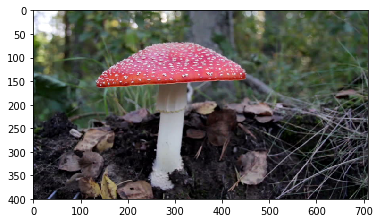

In [94]:
#helper function for resizing images
def resize(img, scale):
    return cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))

im = cv2.imread("test.jpg")
if im.shape[0] > 400:
    scale = 400.0/im.shape[0]
else: scale = 1
im = resize(im, scale)

plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.show()

In [95]:
def preprocess(image, lower, upper):
    #boundary in bgr color scheme for opencv

    lower = np.array(lower, dtype="uint8")
    upper = np.array(upper, dtype="uint8")

    # find the colors within the specified boundaries and apply
    # the mask
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    #This takes image[x] and image[x] when mask is 1 (that is, it leaves it alone),
    #otherwise it makes image[x] = 0. The effect in this case is just image and mask. 
    #This is applied to all 3 channels
    
    return output, mask

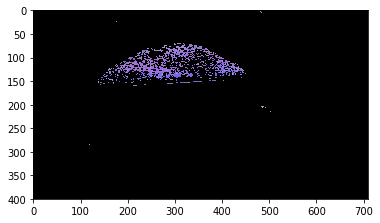

In [143]:
pimage, mask = preprocess(im,  [100,100,180], [170, 170, 255])
plt.imshow(pimage)
plt.show()

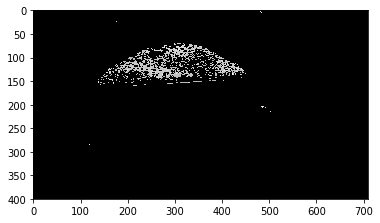

In [144]:
imgray = cv2.cvtColor(pimage,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray, cmap='gray')
plt.show()

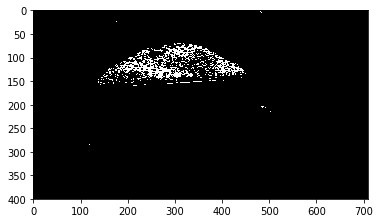

In [145]:
flag, binaryImage = cv2.threshold(imgray, 85, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )
plt.imshow(binaryImage, cmap='gray')
plt.show()

In [146]:
#the actual algorithm is described in 
im2, contours, hierarchy = cv2.findContours(binaryImage,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

386
3


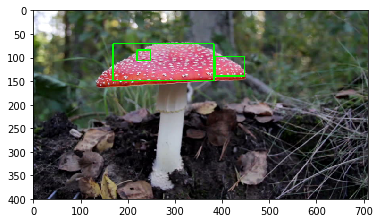

In [147]:
copy = im.copy()
rgb = cv2.cvtColor(copy, cv2.COLOR_BGR2RGB)

boxes = [cv2.boundingRect(c) for c in contours]
print(len(boxes))
boxes2 = [b for b in boxes if b[2]*b[3] > 600]
print(len(boxes2))

for x, y, w, h in boxes2:
    cv2.rectangle(rgb, (x,y),(x+w, y+h), (0, 255, 0), 2)
plt.imshow(rgb)
plt.show()

In [148]:
def transform_scale(factor, boxes):
    return [[int(x[0]*factor), int(x[1]*factor), int(x[2]*factor), int(x[3]*factor)] for x in boxes]

In [149]:

real_signs = []

for x, y, w, h in boxes2:
    #get slice at box:
    window = im[y:y+h, x:x+w, :3]
    window = cv2.resize(window, dims)
    feat = hog.compute(window)
    prob = lsvm.predict_proba(feat.reshape(1,-1))[0]          
#     plt.imshow(cv2.cvtColor(window, cv2.COLOR_BGR2RGB))
#     plt.show()
#     print prob[1]
    if prob[1] > .1:  
        real_signs.append((x,y,w,h))
    
print(len(real_signs))

2


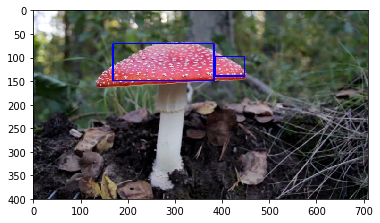

In [150]:
clone = im.copy()

colors = [(0,255,0),(0,0,0),(255,0,255),(255,0,0),(255,165,0),(255,255,255), (1, 1, 1)]
for x, y, w, h in real_signs:
     

    cv2.rectangle(clone, (x, y), (x+w, y+h), colors[3], 2)

plt.imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
plt.show()